<ipython-input-1-6563c70a5ed5>:79: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(


Fitting 10 folds for each of 48 candidates, totalling 480 fits


Best MSE: -0.008168 using {'batch_size': 16, 'dense_units': 64, 'dropout_rate': 0.1, 'epochs': 10, 'num_heads': 4}
Epoch 1/10
46/46 [==============================] - 2s 16ms/step - loss: 0.0192 - val_loss: 0.0531
Epoch 2/10
46/46 [==============================] - 1s 12ms/step - loss: 0.0084 - val_loss: 0.0565
Epoch 3/10
46/46 [==============================] - 1s 12ms/step - loss: 0.0082 - val_loss: 0.0628
Epoch 4/10
46/46 [==============================] - 1s 11ms/step - loss: 0.0084 - val_loss: 0.0636
Epoch 5/10
46/46 [==============================] - 1s 12ms/step - loss: 0.0085 - val_loss: 0.0526
Epoch 6/10
46/46 [==============================] - 1s 13ms/step - loss: 0.0080 - val_loss: 0.0575
Epoch 7/10
46/46 [==============================] - 1s 18ms/step - loss: 0.0078 - val_loss: 0.0611
Epoch 8/10
46/46 [==============================] - 1s 18ms/step - loss: 0.0079 - val_loss: 0.0581
Epoch 9/10
46/46 [==============================] - 1s 19ms/step - loss: 0.0077 - val_loss: 0

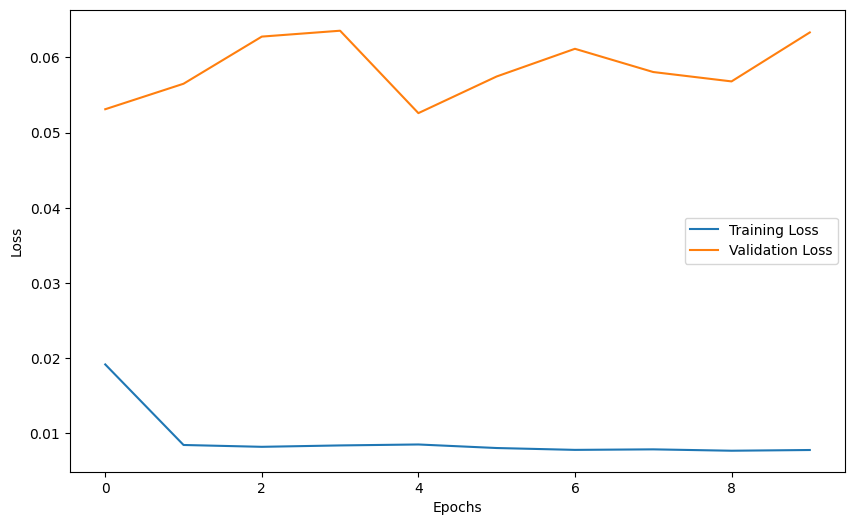

AttributeError: ignored

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.models import Model
from keras.layers import Input, MultiHeadAttention, Dense, Flatten
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:(i + seq_len)])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 90 # Sequence length
split_ratio = 0.8  # Train-test split ratio

def preprocess_data(data, seq_len, split_ratio):
    # Kept only the 'Open' prices
    prices = data[['Open']]

    # Normalized the data
    scaler = MinMaxScaler()
    prices_scaled = scaler.fit_transform(prices.values)

    # Splitting the data into training and test sets
    train_data_len = int(prices_scaled.shape[0] * split_ratio)
    train_data = prices_scaled[:train_data_len]
    test_data = prices_scaled[train_data_len - seq_len:]

    # Creating sequences
    X_train, y_train = create_sequences(train_data, seq_len)
    X_test, y_test = create_sequences(test_data, seq_len)

    # Reshaping input to the required format for transformers
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, y_train, X_test, y_test, prices_scaled, scaler

def build_transformer_model_with_dropout(input_shape, num_heads, dropout_rate, dense_units):
    input_layer = Input(shape=input_shape)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1])(input_layer, input_layer, input_layer)
    dropout = Dropout(dropout_rate)(attention)
    flatten = Flatten()(dropout)
    dense = Dense(dense_units, activation='relu')(flatten)
    output_layer = Dense(1)(dense)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

def create_model(input_shape, num_heads=8, dropout_rate=0.2, dense_units=128):
    model = build_transformer_model_with_dropout(input_shape, num_heads, dropout_rate, dense_units)
    return model

data = pd.read_csv('MANU_3 years.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

X_train, y_train, X_test, y_test, prices_scaled, scaler = preprocess_data(data, SEQ_LEN, split_ratio)

input_shape = (SEQ_LEN, 1)

param_grid = {
    'epochs': [10, 20, 40],
    'batch_size': [16, 32],
    'num_heads': [4, 8],
    'dropout_rate': [0.1, 0.2],
    'dense_units': [64, 128]
}

model = KerasRegressor(
    build_fn=lambda num_heads, dropout_rate, dense_units: create_model(
        input_shape=input_shape, num_heads=num_heads, dropout_rate=dropout_rate, dense_units=dense_units
    ),
    verbose=0
)

tscv = TimeSeriesSplit(n_splits=10)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)
grid_result = grid.fit(X_train, y_train)

print("Best MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
best_batch_size = grid_result.best_params_['batch_size']
best_epochs = grid_result.best_params_['epochs']
best_num_heads = grid_result.best_params_['num_heads']
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_dense_units = grid_result.best_params_['dense_units']

best_model = build_transformer_model_with_dropout(input_shape, num_heads=best_num_heads, dropout_rate=best_dropout_rate, dense_units=best_dense_units)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = best_model.fit(
    X_train, y_train,
    batch_size=best_batch_size,
    epochs=best_epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

best_model.summary()

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)


7/7 [==============================] - 0s 11ms/step
               MAE        MSE      RMSE       MAPE
Training  1.058380   2.003747  1.415538   6.522486
Testing   2.968481  17.281959  4.157158  16.238779
1/1 [==============================] - 0s 25ms/step
            Predicted Open
2023-03-01       17.722651
2023-03-02       17.776682
2023-03-03       17.826054
2023-03-06       17.884769
2023-03-07       17.951464
2023-03-08       18.010473
2023-03-09       18.074553
2023-03-10       18.139553
2023-03-13       18.202978
2023-03-14       18.261105
2023-03-15       18.324663
2023-03-16       18.386858
2023-03-17       18.451540
2023-03-20       18.521603
2023-03-21       18.593384


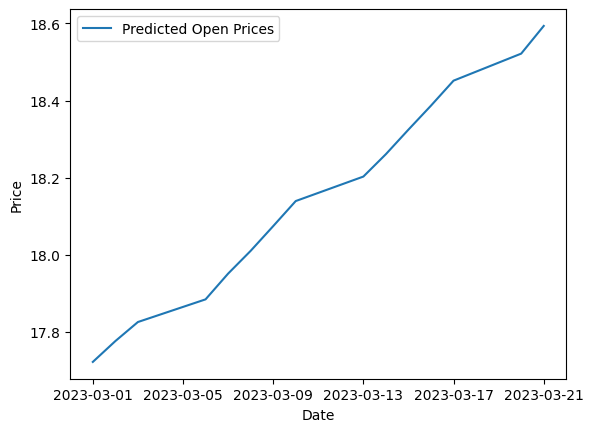

In [ ]:
## Model evaluation
# Predicting the stock prices
y_pred = best_model.predict(X_test)

# Inverse scaled the predictions
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculated mean absolute error, mean squared error, root mean squared error, and mean absolute percentage error
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, rmse, mape

# Training evaluation
y_train_pred = best_model.predict(X_train)
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_train_rescaled = scaler.inverse_transform(y_train)

train_mae, train_mse, train_rmse, train_mape = evaluate(y_train_rescaled, y_train_pred_rescaled)

# Test evaluation
y_pred = best_model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

test_mae, test_mse, test_rmse, test_mape = evaluate(y_test_rescaled, y_pred_rescaled)

# Created a DataFrame with the evaluation metrics
evaluation_df = pd.DataFrame(
    data=[[train_mae, train_mse, train_rmse, train_mape],
          [test_mae, test_mse, test_rmse, test_mape]],
    columns=['MAE', 'MSE', 'RMSE', 'MAPE'],
    index=['Training', 'Testing']
)

print(evaluation_df)

# Created a function to predict future prices
def predict_future_prices(model, last_sequence, num_days):
    predictions = []
    sequence = last_sequence.copy()

    for i in range(num_days):
        new_prediction = model.predict(sequence.reshape(1, SEQ_LEN, 1))
        predictions.append(new_prediction[0])
        sequence = np.append(sequence[1:], new_prediction)

    return np.array(predictions)

# Predicted the 'Open' prices from 1st March 2023 to 15th March 2023
num_days = 15
last_sequence = prices_scaled[-SEQ_LEN:].reshape(SEQ_LEN, 1)
future_predictions = predict_future_prices(best_model, last_sequence, num_days)

# Inverse scaled the predictions
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Created a DataFrame for the predicted 'Open' prices
prediction_dates = pd.date_range(start='2023-03-01', periods=num_days, freq='B')
predicted_prices_df = pd.DataFrame(data=future_predictions_rescaled, index=prediction_dates, columns=['Predicted Open'])

print(predicted_prices_df)

# Plotted the predicted 'Open' prices from 1st March 2023 to 15th March 2023
plt.plot(predicted_prices_df.index, predicted_prices_df['Predicted Open'], label='Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()